# Building a support chatbot in LangGraph

## Setup

In [3]:
%%capture --no-stderr
%pip install -U langgraph langsmith

In [1]:
import getpass
import os 

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("LANGSMITH_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "LangGraph Tutorial"

## 1. Build a basic chatbot

In [3]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Type of messages: list
    # `add_messages`: how this state key should be updated
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

1. Node
    - INPUT: the current State
    - OUTPUT: a value that updates the state
2. messages
    - appended to the current list
    - communicated via `add_messages` in `Annotated`

In [5]:
from langchain_ollama import ChatOllama

llm = ChatOllama(model="llama3.1")

def chatbot(state: State):
    return{"messages": [llm.invoke(state["messages"])]}

# 1st arg: unique node name
# 2nd arg: function or object called whenever the node's used
graph_builder.add_node("chatbot", chatbot)

`entry`: Where to start its work

In [6]:
graph_builder.add_edge(START, "chatbot")

`finish`: any time this node is run, you can exit

In [7]:
graph_builder.add_edge("chatbot", END)

`CompiledGraph`: we can use invoke on our state

In [8]:
graph = graph_builder.compile()

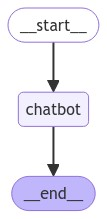

In [10]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # (Optional) extra dependecies
    pass

In [11]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye")
        break
    for event in graph.stream({"messages": ("user", user_input)}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

Assistant: I couldn't find any information on "langgraph." It's possible that it's a misspelling, a made-up word, or something very niche.

However, I can think of a few possibilities:

1. **Language graph**: This could be a concept in linguistics or computer science related to visualizing language data, such as the structure and relationships between words, concepts, or entities.
2. **LanguagE Graph**: A more plausible interpretation is that langgraph is an abbreviation for "language engineering graph," which might refer to a framework or tool for representing and analyzing linguistic information in a graphical format.

If none of these possibilities resonate with you, could you please provide more context about where you heard of langgraph? I'd be happy to try and help clarify what it's all about!
Assistant: It seems that you forgot to ask a question or provide any context for our conversation. I'd be happy to chat with you, but I need something to respond to.

If you're ready, we ca

## 2. Enhencing the Chatbot with Tools

In [21]:
%%capture --no-stderr
%pip install -U tavily-python
%pip install -U langchain_community

### Requireements

In [2]:
_set_env("TAVILY_API_KEY")

In [4]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

[{'url': 'https://langchain-ai.github.io/langgraph/concepts/low_level/',
  'content': 'Nodes¶ In LangGraph, nodes are typically python functions (sync or async) where the first positional argument is the state, and (optionally), the second positional argument is a "config", containing optional configurable parameters (such as a thread_id). Similar to NetworkX, you add these nodes to a graph using the add_node method:'},
 {'url': 'https://medium.com/@kbdhunga/beginners-guide-to-langgraph-understanding-state-nodes-and-edges-part-1-897e6114fa48',
  'content': 'Each node in a LangGraph graph has the ability to access, read, and write to the state. When a node modifies the state, it effectively broadcasts this information to all other nodes within the graph .'}]

**The same as in Part 1**

In [6]:
from typing import Annotated

from langchain_ollama import ChatOllama
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


llm = ChatOllama(model="llama3.1")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

`BasicToolNode`
- checkts the most recent message in the state and calls tools if the message contains `tool_calls`.
- relies on the LLM's `tool_calling` support


In [7]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

`route_tools`: checks for tool_calls in the chatbot's output.
`add_conditional_edges`: tells the graph that whenever the `chatbot` ndoe completes to check this function.

In [8]:
from typing import Literal


def route_tools(
    state: State,
) -> Literal["tools", "__end__"]:
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return "__end__"


graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    {"tools": "tools", "__end__": "__end__"},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

**Notice** that conditional edges start from a single node. This tells the graph "any time the 'chatbot' node runs, either go to 'tools' if it calls a tool, or end the loop if it responds directly.

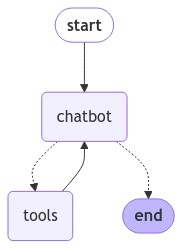

In [9]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [11]:
from langchain_core.messages import BaseMessage

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            if isinstance(value["messages"][-1], BaseMessage):
                print("Assistant:", value["messages"][-1].content)

Assistant: 
Assistant: [{"url": "https://www.langchain.com/langgraph", "content": "LangGraph is a framework for building stateful, multi-actor agents with LLMs that can handle complex scenarios and collaborate with humans. Learn how to use LangGraph with Python or JavaScript, and deploy your agents at scale with LangGraph Cloud."}, {"url": "https://github.com/langchain-ai/langgraph", "content": "LangGraph is a framework for creating stateful, multi-actor applications with LLMs, using cycles, controllability, and persistence. It integrates with LangChain and LangSmith, and supports human-in-the-loop and streaming features."}]
Assistant: Based on the tool call response, it appears that LangGraph is a framework used for building stateful, multi-actor agents with Large Language Models (LLMs) that can handle complex scenarios and collaborate with humans. It provides tools for creating stateful applications using cycles, controllability, and persistence, and integrates with other AI framewor

## 3. Adding memory to the chatbot

In [2]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In a production app, Change this to use SqliteSaver or PostgresSaver.

In [4]:
from typing import Annotated

from langchain_ollama import ChatOllama
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOllama(model="llama3.1")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the nxt step
graph_builder.add_edge("tools", "chatbot") 
graph_builder.add_edge(START, "chatbot") 

In [5]:
graph = graph_builder.compile(checkpointer=memory)

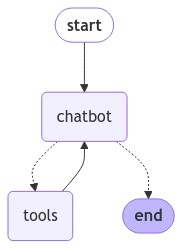

In [6]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # Optional
    pass

In [7]:
config = {"configurable": {"thread_id": "1"}}

In [8]:
user_input = "Hi there! My name is Dustin."

# config: 2nd arg to stream() or invoke()
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Dustin.
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (24d26d4e-f8ae-4339-84da-871207d8a4a3)
 Call ID: 24d26d4e-f8ae-4339-84da-871207d8a4a3
  Args:
    query: Dustin
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://nameberry.com/b/boy-baby-name-dustin", "content": "Dustin is a Scandinavian and Norse name meaning \"brave warrior, or Thor's stone\". It is a classic name that has been influenced by actors, athletes, and a Netflix character."}, {"url": "https://www.dustingroup.com/", "content": "About Dustin Group. Dustin is a leading online based IT partner in the Nordics and Benelux. We help our customers to stay in the forefront by providing them with the right IT solution at the right time and at the right price. 23.6 BSEK. Net

In [9]:
user_input = "Remember my name?"

# config: 2nd arg to stream() or invoke()
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (b5449206-5a5d-4fee-b100-8e51a8186630)
 Call ID: b5449206-5a5d-4fee-b100-8e51a8186630
  Args:
    query: Dustin
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://nameberry.com/b/boy-baby-name-dustin", "content": "Dustin is a Scandinavian and Norse name meaning \"brave warrior, or Thor's stone\". It is a classic name that has been influenced by actors, athletes, and a Netflix character."}, {"url": "https://www.dustingroup.com/", "content": "About Dustin Group. Dustin is a leading online based IT partner in the Nordics and Benelux. We help our customers to stay in the forefront by providing them with the right IT solution at the right time and at the right price. 23.6 BSEK. Net sales."}]


In [10]:
# Difference: thread_id, 2
events = graph.stream(
    {"messages": [("user", user_input)]},
    {"configurable": {"thread_id": 2}},
    stream_mode="values",
) 
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (a4de74a7-3ac9-4771-ae64-f0a1d5cff0e2)
 Call ID: a4de74a7-3ac9-4771-ae64-f0a1d5cff0e2
  Args:
    query: What is your name?
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://en.wikipedia.org/wiki/Your_Name", "content": "In its first week, the Blu-ray standard edition sold 202,370 units, the collector's edition sold 125,982 units and the special edition sold 94,079 units.[49] The DVD Standard Edition placed first, selling 215,963.[50] Your Name is the first anime to place three Blu-ray Disc releases in the top 10 of Oricon's overall Blu-ray Disc chart for 2 straight weeks.[51] In 2017, the film generated \u00a56,532,421,094 ($58,238,797) in media revenue from physical home video, soundtr

In [11]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Dustin.', id='18f466a5-155d-4277-a4e9-ff973084b245'), AIMessage(content='', response_metadata={'model': 'llama3.1', 'created_at': '2024-09-12T04:21:59.288647Z', 'message': {'role': 'assistant', 'content': '', 'tool_calls': [{'function': {'name': 'tavily_search_results_json', 'arguments': {'query': 'Dustin'}}}]}, 'done_reason': 'stop', 'done': True, 'total_duration': 19386192583, 'load_duration': 14282143000, 'prompt_eval_count': 194, 'prompt_eval_duration': 3885454000, 'eval_count': 22, 'eval_duration': 1196266000}, id='run-1c40d14e-f411-4cef-8bb5-61f474b1948f-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Dustin'}, 'id': '24d26d4e-f8ae-4339-84da-871207d8a4a3', 'type': 'tool_call'}], usage_metadata={'input_tokens': 194, 'output_tokens': 22, 'total_tokens': 216}), ToolMessage(content='[{"url": "https://nameberry.com/b/boy-baby-name-dustin", "content": "Dustin is a Scandinavian and No

In [12]:
snapshot.next

()

## 4. Human-in-the-loop

In [18]:
from typing import Annotated

from langchain_ollama import ChatOllama
from langchain_community.tools.tavily_search import TavilySearchResults
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

memory = MemorySaver()


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOllama(model="llama3.1")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [20]:
graph = graph_builder.compile(
    checkpointer=memory,
    # New!
    interrupt_before=["tools"],
    # interrupt_after=["tools"]                      
)

In [21]:
user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (85f285f2-894d-473e-a78c-e1eb176cb927)
 Call ID: 85f285f2-894d-473e-a78c-e1eb176cb927
  Args:
    query: LangGraph


In [22]:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

Notice that "next": 'tools' 

In [23]:
existing_message = snapshot.values["messages"][-1]
existing_message.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'LangGraph'},
  'id': '85f285f2-894d-473e-a78c-e1eb176cb927',
  'type': 'tool_call'}]

In [25]:
# `None`: nothing new
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

Based on the search results I found for you:

LangGraph is a framework that allows you to build stateful, multi-actor agents using Large Language Models (LLMs). It simplifies the development of complex applications by providing tools for node creation, edge management, and state management. You can use LangGraph with either Python or JavaScript, and it also has cloud deployment capabilities through LangGraph Cloud.

If you'd like to learn more about how to use LangGraph in a tutorial setting, I found a resource on DataCamp that provides an introduction to the library and its features. Let me know if you have any other questions!


## 5. Manually updating the state

In [6]:
from typing import Annotated

from langchain_ollama import ChatOllama
from langchain_community.tools.tavily_search import TavilySearchResults
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOllama(model="llama3.1")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,
    # New!
    interrupt_before=["tools"]
    # interrupt_after=["tools"]
)

user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "1"}}
# config: 2nd arg to stream() or invoke()
events = graph.stream({"messages": [("user", user_input)]}, config)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()


In [8]:
snapshot = graph.get_state(config)
existing_message = snapshot.values["messages"][-1]
existing_message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (7f21580a-aedc-404e-9c01-13c11bf245dc)
 Call ID: 7f21580a-aedc-404e-9c01-13c11bf245dc
  Args:
    query: LangGraph


Provide the correct response

In [12]:
from langchain_core.messages import AIMessage, ToolMessage

answer = (
    "LangGraph is a library for building stateful, multi-actor applications with LLMs."
)
new_messages = [
    # ToolMessage for LLM API
    ToolMessage(content=answer, tool_call_id=existing_message.tool_calls[0]["id"]),
    # Populating its response
    AIMessage(content=answer)
]

new_messages[-1].pretty_print()
graph.update_state(
    # Which state to update
    config,
    # The messages will be appended to the existing state
    {"messages": new_messages},
)
print("\n\nLast 2 messages;")
print(graph.get_state(config).values["messages"][-2:])


================================== Ai Message ==================================

LangGraph is a library for building stateful, multi-actor applications with LLMs.


Last 2 messages;
[ToolMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', id='59ee8764-79bc-438e-9030-6c1086fee133', tool_call_id='7f21580a-aedc-404e-9c01-13c11bf245dc'), AIMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', id='3a15f886-9cca-4e29-8b26-9e54ac2261dc')]


**Notice**: Our new messages are appended to the messages already in the state.

In [13]:
graph.update_state(
    config,
    {"messages": [AIMessage(content="I'm an AI expert!")]},
    # continue processing as if this node just ran
    as_node="chatbot"
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef71766-c7a1-67d8-8003-c2215b05c5c8'}}

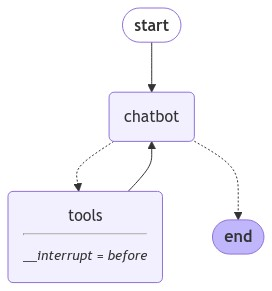

In [14]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # optional
    pass

In [15]:
snapshot = graph.get_state(config)
print(snapshot.values["messages"][-3:])
print(snapshot.next)

[ToolMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', id='59ee8764-79bc-438e-9030-6c1086fee133', tool_call_id='7f21580a-aedc-404e-9c01-13c11bf245dc'), AIMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', id='3a15f886-9cca-4e29-8b26-9e54ac2261dc'), AIMessage(content="I'm an AI expert!", id='b4068d7e-5f72-4064-88c1-df72f7850a12')]
()


**Notice** Acting as the `chatbot` and responding with an AIMessages without `toolcalls`

### What if you want to overwrite existing messages?